# Calculate relationship between AP and dendritic spikes with poisson excitation and rhythmic inhibition

The simulations had either: 
1. Rhythmic inhibition at the soma (64 Hz) or dendrites (16 Hz) 
2. Poisson excitation at the soma and dendrites

Here we calculate the spike-triggered average between dendritic spikes and action potentials. These are stratified by:
1. electrotonic distance of the dendritic segment from the soma
2. whether the dendritic branch was apical or basal
3. type of dendritic spike

The output of this script are a collection of NPY files, one for each simulation condition, dendrite type, and dendritic spike type, containing a numpy array with 3 dimensions:
1. the dendritic segment electrotonic quantile
2. time from the action potential

In [1]:
import sys
sys.path.append('..') # have to do this for relative imports in jupyter
import numpy as np
import pandas as pd
from scipy.signal import hilbert
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from src.bin_rhythmic_files import bin_rhythmic_files
from src.load_spike_h5 import load_spike_h5
from src.ser_pt import ser_pt
from src.bin_serser import bin_serser
from src.cc_phdep_files import cc_phdep_files

from src.load_dendevt_csv import load_dendevt_csv
from src.seg_dendevt import seg_dendevt
from src.ser_seg_dendevt import ser_seg_dendevt
from src.mean_dendevt import mean_dendevt

## 1.0 Analysis parameters


### 1.1 Simulation constants and analysis windows

In [2]:
samps_per_ms = 10 
sim_win = [0, 2000000] # beginning and start points of simulation in samples
sta_win = [-100, 100] # multiply by step to get window in milliseconds
sta_step = 1 # binning step for each point in the STA
step = 2 * samps_per_ms # number of simulation steps for creating the dendritic 
                        # event occurrence series
ph_bin_num = 8
edges = np.linspace(-np.pi, np.pi, ph_bin_num)

### 1.2 List files to be processed

In [3]:
# locate simulation files
root_16_dir = 'Y:\\DendCompOsc\\output_16Hz_no_exc_mod\\'
sim_16_dict = {'SimName': 'output_16Hz_no_exc_mod',
               'RootDir': root_16_dir,
               'CaFile': root_16_dir + 'output_16Hz_no_exc_mod_ca.csv',
               'NaFile': root_16_dir + 'output_16Hz_no_exc_mod_na.csv',
               'NMDAFile': root_16_dir + 'output_16Hz_no_exc_mod_nmda.csv',
               'APFile': root_16_dir + 'spikes.h5'}

root_64_dir = 'Y:\\DendCompOsc\\output_64Hz_no_exc_mod\\'
sim_64_dict = {'SimName': 'output_64Hz_no_exc_mod',
               'RootDir': root_64_dir,
               'CaFile': root_64_dir + 'output_64Hz_no_exc_mod_ca.csv',
               'NaFile': root_64_dir + 'output_64Hz_no_exc_mod_na.csv',
               'NMDAFile': root_64_dir + 'output_64Hz_no_exc_mod_nmda.csv',
               'APFile': root_64_dir + 'spikes.h5'}


## 2.0 Phase binned histograms for dendritic and somatic spikes

### 2.1 Generate phase series for each experiment

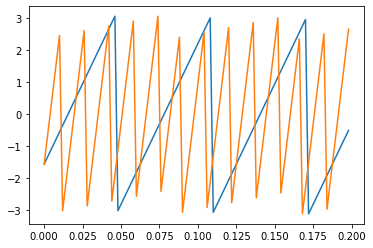

In [4]:
# generate phase time series for inhibitory afferents
t_ser = np.arange(sim_win[0], sim_win[1], step) / (10000) # seconds
sin_16_ser = np.sin(t_ser*16*2*np.pi)
sin_64_ser = np.sin(t_ser*64*2*np.pi)
ph_16_ser = np.angle(hilbert(sin_16_ser))
ph_64_ser = np.angle(hilbert(sin_64_ser))

fig, ax = plt.subplots()
ax.plot(t_ser[0:100],ph_16_ser[0:100])
ax.plot(t_ser[0:100],ph_64_ser[0:100])
plt.show()

### 2.2 Calculate phase binned histograms

In [60]:
# phase bin dendritic and action potential files function
def bin_files_func(sim_dict, ph_ser, sin_ser):
    ph_bin = {}

    # process dendritic events
    ph_bin['ca_bin'] = bin_rhythmic_files(sim_dict['CaFile'], ph_ser, step, sim_win,ph_bin_num)
    ph_bin['nmda_bin'] = bin_rhythmic_files(sim_dict['NMDAFile'], ph_ser, step, sim_win,ph_bin_num)
    ph_bin['na_bin'] = bin_rhythmic_files(sim_dict['NaFile'], ph_ser, step, sim_win,ph_bin_num)

    ph_bin['ca_a'] = ph_bin['ca_bin'].loc['apic','ph_bin']
    ph_bin['nmda_a'] = ph_bin['nmda_bin'].loc['apic','ph_bin']
    ph_bin['nmda_b'] = ph_bin['nmda_bin'].loc['dend','ph_bin']
    ph_bin['na_a'] = ph_bin['na_bin'].loc['apic','ph_bin']
    ph_bin['na_b'] = ph_bin['na_bin'].loc['dend','ph_bin']
    

    # process action potential events
    spk_t = load_spike_h5(sim_dict['APFile'])
    spk_ser = ser_pt(spk_t, step, sim_win)
    spk_ser = np.array(spk_ser)*500
    # multiplying by 500 converts to firing rates, 2ms bin means 1 spike per bin
    # is a firing rate of 500 Hz.
    ph_bin['ap'] = bin_serser(spk_ser.astype(float), ph_ser, edges, func=np.nanmean)["values"]
    ph_bin['sin'] = bin_serser(sin_ser, ph_ser, edges, func=np.nanmean)["values"]
    return ph_bin



In [61]:
# process the 16 Hz distal dendritic inhibition simulation
ph_16_bin = bin_files_func(sim_16_dict, ph_16_ser, sin_16_ser)

# process the 64 Hz proximal dendritic/somatic inhibition simulation
ph_64_bin = bin_files_func(sim_64_dict, ph_64_ser, sin_64_ser)

c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\InhibOnDendComp\scripts\..\src\bin_serser.py:50: RuntimeWarning: Mean of empty slice
  bin_temp.append(func(val_ser[bin_inds == curr_ind]))
c:\Users\dbh60\.conda\envs\ds\lib\site-packages\numpy\lib\nanfunctions.py:1119: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\InhibOnDendComp\scripts\..\src\bin_rhythmic_files.py:47: DtypeWarning: Columns (11) have mixed types.Specify dtype option on import or set low_memory=False.
  dend_t = load_dendevt_csv(dend_fname)


### 2.3 Plots

In [97]:
# plotting functions
def stairs_plot(sig_ser, sin_ser, ax):
        sc_func = lambda x: ((x+1)/2)*np.max(sig_ser[1:])

        ax.stairs(np.hstack((sig_ser[1:],sig_ser[1:])),
                        np.hstack((edges[:-1], edges+2*np.pi)), 
                        baseline=0, fill=True)
        ax.plot(np.hstack((edges, edges+2*np.pi)), 
                np.hstack((sc_func(sin_ser), sc_func(sin_ser))),color='k')
        ax.plot(np.linspace(-np.pi,3*np.pi,100),
                sc_func(np.sin(np.linspace(-np.pi,3*np.pi,100))), 
                color='r', linestyle=':')
        ax.set_xticks(np.pi/2*np.arange(-2,7))
        ax.tick_params(axis='x', rotation=90)

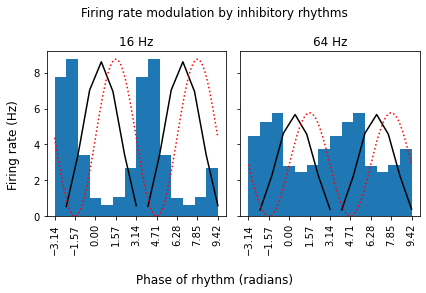

In [115]:
# Action potentials
fig, ax = plt.subplots(1,2,sharey=True)
stairs_plot(ph_16_bin['ap'], ph_16_bin['sin'], ax[0])
stairs_plot(ph_64_bin['ap'], ph_64_bin['sin'], ax[1])
ax[0].set_title('16 Hz')
ax[1].set_title('64 Hz')
fig.suptitle('Firing rate modulation by inhibitory rhythms')
fig.supxlabel('Phase of rhythm (radians)')
fig.supylabel('Firing rate (Hz)')
plt.tight_layout()
plt.show()


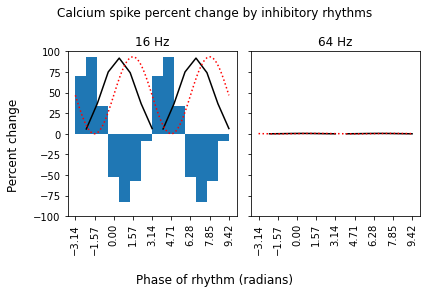

In [116]:
# calcium spikes
fig, ax = plt.subplots(1,2,sharey=True)
stairs_plot(ph_16_bin['ca_a'][0], ph_16_bin['sin'], ax[0])
stairs_plot(ph_64_bin['ca_a'][0], ph_64_bin['sin'], ax[1])
ax[0].set_ylim([-100,100])
ax[0].set_title('16 Hz')
ax[1].set_title('64 Hz')
fig.suptitle('Calcium spike percent change by inhibitory rhythms')
fig.supxlabel('Phase of rhythm (radians)')
fig.supylabel('Percent change')
plt.tight_layout()
plt.show()

#### Plot percent change in dendritic event occurrence with repect to APs

In [112]:
# plot phase-dependent modulation of dendritic events stratified by electrotonic distance
eqt_list = np.arange(9,0,-1)
eqt_inds = np.where(eqt_list>0)[0]
def plot_sta_im(data_arr,vlim, ax):
    ax_im = ax.imshow(np.hstack((data_arr[eqt_inds[0]:eqt_inds[-1],1:], 
                                 data_arr[eqt_inds[0]:eqt_inds[-1],1:])),
                      extent=[-np.pi, 3*np.pi, eqt_list[eqt_inds[0]], eqt_list[eqt_inds[-1]]],
                      vmin=vlim[0], vmax=vlim[1],
                      interpolation='none',
                      cmap='coolwarm')
    
    plt.colorbar(ax_im,ax=ax)
    ax.set_aspect('auto')

# array plots
def plot_dend_set(ph_bin_data, vlim, fig, ax):
    plot_sta_im(ph_bin_data['nmda_a'], vlim, ax[0,0])
    ax[0,0].set_title('NMDA Apical')
    ax[0,0].set_xticks(np.pi/2*np.arange(-2,7))
    ax[0,0].tick_params(axis='x', rotation=90)
    plot_sta_im(ph_bin_data['nmda_b'], vlim, ax[1,0])
    ax[1,0].set_title('NMDA Basal')
    ax[1,0].set_xticks(np.pi/2*np.arange(-2,7))
    ax[1,0].tick_params(axis='x', rotation=90)
    plot_sta_im(ph_bin_data['na_a'], vlim, ax[0,1])
    ax[0,1].set_title('Na Apical')
    ax[0,1].set_xticks(np.pi/2*np.arange(-2,7))
    ax[0,1].tick_params(axis='x', rotation=90)
    plot_sta_im(ph_bin_data['na_b'], vlim, ax[1,1])
    ax[1,1].set_title('Na Basal')
    ax[1,1].set_xticks(np.pi/2*np.arange(-2,7))
    ax[1,1].tick_params(axis='x', rotation=90)
    fig.supxlabel('Phase of rhythm (radians)')
    fig.supylabel('Electrotonic quantile 90->0')
    

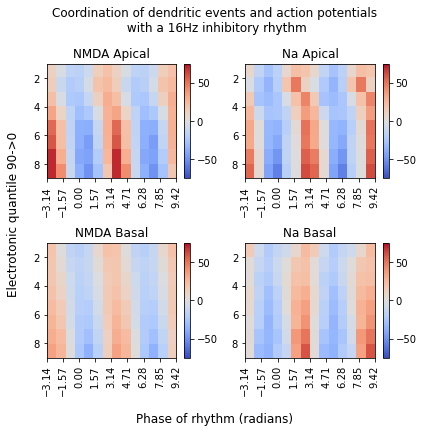

In [113]:
# plot of NMDA and Na spikes for 16 hz dend inhib
fig,ax = plt.subplots(2,2)
plot_dend_set(ph_16_bin, [-75, 75], fig, ax)
fig.suptitle('Coordination of dendritic events and action potentials\n'
             + ' with a 16Hz inhibitory rhythm')
fig.set_size_inches(6,6)
fig.tight_layout()


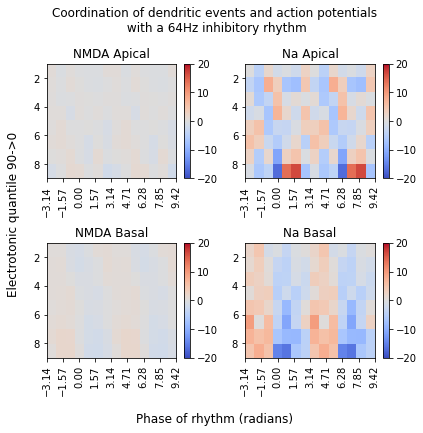

In [114]:
# plot of NMDA and Na spikes for 64 hz somatic inhib
fig,ax = plt.subplots(2,2)
plot_dend_set(ph_64_bin, [-20, 20], fig, ax)
fig.suptitle('Coordination of dendritic events and action potentials\n'
             + ' with a 64Hz inhibitory rhythm')
fig.set_size_inches(6,6)
fig.tight_layout()

## 3.0 Phase-dependent modulation of AP/dendritic spike coupling

### 3.1 Calculate phase-dependent cross-correlations

In [5]:
# trying out cc
nmda_file = sim_64_dict['NMDAFile']
ap_file = sim_64_dict['APFile']

ph_mask = sin_64_ser >= 0

# process action potential events
spk_t = load_spike_h5(ap_file)
spk_ser = ser_pt(spk_t, step, sim_win).to_numpy()

# create spike series and keep only those with the right phase
spk_ser_t = spk_ser.copy()
spk_ser_p = spk_ser.copy()
spk_ser_t[np.where(ph_mask)[0]] = 0
spk_ser_p[np.where(~ph_mask)[0]] = 0

# turn dendritic events into series
dend_t = load_dendevt_csv(nmda_file)
dend_seg = seg_dendevt(dend_t)
dend_seg = ser_seg_dendevt(dend_seg, step_len=step, win_lim=sim_win)
dend_seg = mean_dendevt(dend_seg)

C:\Users\dbh60\AppData\Local\Temp/ipykernel_10388/1906831417.py:18: DtypeWarning: Columns (11) have mixed types.Specify dtype option on import or set low_memory=False.
  dend_t = load_dendevt_csv(nmda_file)
c:\Users\dbh60\.conda\envs\ds\lib\site-packages\pandas\core\apply.py:436: FutureWarning: Dropping invalid columns in SeriesGroupBy.agg is deprecated. In a future version, a TypeError will be raised. Before calling .agg, select only columns which should be valid for the aggregating function.
  key: obj._gotitem(key, ndim=1).agg(how) for key, how in arg.items()


TypeError: <lambda>() missing 1 required positional argument: 'm'

In [12]:
# Corrected cross covariance stratified by inhibitory phase
# in this function, trough refers to the lull in inhibitory afferents, while peak
# is the maximum of inhibitory afferents
def cc_corr_func(sim_dict, sin_ser):
    ph_cc = {}

    ph_cc['ca_cc'] = cc_phdep_files(sim_dict['CaFile'], sim_dict['APFile'], sin_ser, step, sim_win, sta_win)
    ph_cc['nmda_cc'] = cc_phdep_files(sim_dict['NMDAFile'], sim_dict['APFile'], sin_ser, step, sim_win, sta_win)
    ph_cc['na_cc'] = cc_phdep_files(sim_dict['NaFile'], sim_dict['APFile'], sin_ser, step, sim_win, sta_win)
    
    ph_cc['ca_a_t'] = ph_cc['ca_cc'].loc['apic','cc_t']
    ph_cc['nmda_a_t'] = ph_cc['nmda_cc'].loc['apic','cc_t']
    ph_cc['nmda_b_t'] = ph_cc['nmda_cc'].loc['dend','cc_t']
    ph_cc['na_a_t'] = ph_cc['na_cc'].loc['apic','cc_t']
    ph_cc['na_b_t'] = ph_cc['na_cc'].loc['dend','cc_t']

    ph_cc['ca_a_p'] = ph_cc['ca_cc'].loc['apic','cc_p']
    ph_cc['nmda_a_p'] = ph_cc['nmda_cc'].loc['apic','cc_p']
    ph_cc['nmda_b_p'] = ph_cc['nmda_cc'].loc['dend','cc_p']
    ph_cc['na_a_p'] = ph_cc['na_cc'].loc['apic','cc_p']
    ph_cc['na_b_p'] = ph_cc['na_cc'].loc['dend','cc_p']

    return ph_cc

In [13]:
# process the 16 Hz distal dendritic inhibition simulation
ph_16_cc = cc_corr_func(sim_16_dict, sin_16_ser)

# process the 64 Hz proximal dendritic/somatic inhibition simulation
ph_64_cc = cc_corr_func(sim_64_dict, sin_64_ser)

c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\InhibOnDendComp\scripts\..\src\cc_phdep_files.py:69: DtypeWarning: Columns (11) have mixed types.Specify dtype option on import or set low_memory=False.
  dend_t = load_dendevt_csv(dend_fname)


### 3.2 Plots

#### Phase-dependence of cross-covariance between dendritic events and action potentials

In [14]:
t_list = np.arange(sta_win[0], sta_win[1], sta_step) * (step / samps_per_ms)
eqt_list = np.arange(9,0,-1)

t_inds = np.where(np.abs(t_list)<=50)[0]
eqt_inds = np.where(eqt_list>0)[0]

def plot_sta_im(data_arr,ax):

    ax_im = ax.imshow(data_arr[eqt_inds[0]:eqt_inds[-1],t_inds[0]:t_inds[-1]], 
                      extent=[t_list[t_inds[0]], t_list[t_inds[-1]],
                              eqt_list[eqt_inds[0]], eqt_list[eqt_inds[-1]]],
                      interpolation='none',
                      cmap='coolwarm'
                    )
    
    plt.colorbar(ax_im,ax=ax)
    ax.axvline(0,color='white',linestyle=':')
    ax.set_aspect('auto')

# array plots
def plot_dend_set(ph_cc_data, vlim, fig, ax):
    plot_sta_im(ph_cc_data['nmda_a_t'], vlim, ax[0,0])
    ax[0,0].set_title('NMDA Apical - Trough')

    plot_sta_im(ph_cc_data['nmda_b_t'], vlim, ax[1,0])
    ax[1,0].set_title('NMDA Basal - Trough')

    plot_sta_im(ph_cc_data['na_a_t'], vlim, ax[2,0])
    ax[2,0].set_title('Na Apical - Trough')

    plot_sta_im(ph_cc_data['na_b_t'], vlim, ax[3,0])
    ax[3,0].set_title('Na Basal - Trough')

    fig.supxlabel('Phase of rhythm (radians)')
    fig.supylabel('Electrotonic quantile 90->0')

KeyError: 'nmda_a'

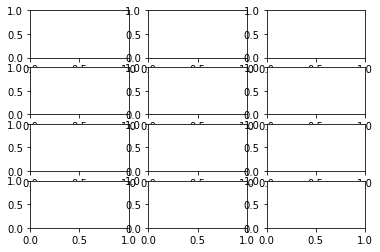

In [15]:
fig, ax = plt.subplots(4,3)
plot_dend_set(ph_16_cc, [-1, 1], fig, ax)

<function matplotlib.pyplot.show(close=None, block=None)>

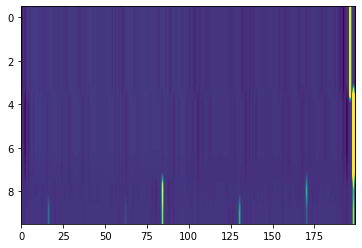

In [19]:
fig, ax = plt.subplots()
ax.imshow(ph_16_cc['na_cc']['cc_corr_y'].loc['apic'], vmax=0.001)
#ax.plot(ph_16_bin['ca_cc']['cc_y'].iloc[0].T)
ax.set_aspect('auto')
plt.show